In [1]:
# !pip install pytorch-forecasting
# !pip install tensorboard
# !pip install tensorboardX
# !pip install pytorch_optimizer

In [1]:
import warnings
import numpy as np
import pandas as pd
import copy
from pathlib import Path
import torch
import torch.nn as nn

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor

import pytorch_forecasting
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/betzflip-env/lib/python3.12/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# 1. Data Preparation with Downsampling
df = pd.read_csv('../data/engine_knock_data_hourly.csv', parse_dates=['Timestamp'])

# removing the Knock and Ignition timing columns
df.drop(columns=['IgnitionTiming'], inplace=True)

In [3]:
df.head()

,Timestamp,Knock,RPM,CylinderPressure,BurnRate,Vibration,EGOVoltage,TempSensor
0,2024-01-01 00:00:00,True,3049.671415,30.226362,8.532683,0.493748,0.30,106.963896
1,2024-01-01 01:00:00,False,3115.583092,20.206043,7.773047,0.005990,0.45,100.848934
2,2024-01-01 02:00:00,False,3314.768854,22.896396,9.217628,0.116642,0.45,110.003050
3,2024-01-01 03:00:00,False,3505.856376,12.276180,0.814754,0.077569,0.45,92.596056
4,2024-01-01 04:00:00,False,3409.597364,16.095535,6.928412,0.069932,0.45,91.748085


In [4]:
df.describe()

,Timestamp,RPM,CylinderPressure,BurnRate,Vibration,EGOVoltage,TempSensor
count,10944,10944.000000,10944.000000,1.094400e+04,10944.000000,10944.000000,10944.000000
mean,2024-08-15 23:30:00,2999.391922,18.191153,4.895806e+00,0.002771,0.449246,95.075532
min,2024-01-01 00:00:00,2183.321743,1.815411,5.572209e-12,-0.180697,0.300000,77.056280
25%,2024-04-23 23:45:00,2662.393725,14.542728,8.462292e-01,-0.067065,0.450000,87.637617
50%,2024-08-15 23:30:00,3004.010533,18.133594,4.893424e+00,0.001653,0.450000,95.115974
75%,2024-12-07 23:15:00,3335.021744,21.927933,8.856497e+00,0.068529,0.450000,102.553649
max,2025-03-31 23:00:00,3802.273670,33.749114,1.005560e+01,0.619625,0.450000,116.842868
std,NaN,366.665316,4.824909,3.763194e+00,0.082154,0.010607,8.677337


In [5]:
df["Knock"] = df['Knock'].astype(int)

In [6]:
# Convert 'Knock' column to string type
df['Knock'] = df['Knock'].astype(str)

In [7]:
df.head()

,Timestamp,Knock,RPM,CylinderPressure,BurnRate,Vibration,EGOVoltage,TempSensor
0,2024-01-01 00:00:00,1,3049.671415,30.226362,8.532683,0.493748,0.30,106.963896
1,2024-01-01 01:00:00,0,3115.583092,20.206043,7.773047,0.005990,0.45,100.848934
2,2024-01-01 02:00:00,0,3314.768854,22.896396,9.217628,0.116642,0.45,110.003050
3,2024-01-01 03:00:00,0,3505.856376,12.276180,0.814754,0.077569,0.45,92.596056
4,2024-01-01 04:00:00,0,3409.597364,16.095535,6.928412,0.069932,0.45,91.748085


In [8]:
# Ensure Timestamp is in the right format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Sort by Timestamp to make sure the data is in order
df = df.sort_values('Timestamp')

# Create time_idx in hours and convert it to integer type
df['time_idx'] = (df['Timestamp'] - df['Timestamp'].min()).dt.total_seconds().div(3600).astype(int)

# Check the data types to confirm time_idx is now an integer
print(df.dtypes)


Timestamp           datetime64[ns]
Knock                       object
RPM                        float64
CylinderPressure           float64
BurnRate                   float64
Vibration                  float64
EGOVoltage                 float64
TempSensor                 float64
time_idx                     int64
dtype: object


In [9]:
df.shape

(10944, 9)

In [10]:
df.tail()

,Timestamp,Knock,RPM,CylinderPressure,BurnRate,Vibration,EGOVoltage,TempSensor,time_idx
10939,2025-03-31 19:00:00,0,2583.022048,18.871620,9.923854,-0.014610,0.45,95.126803,10939
10940,2025-03-31 20:00:00,0,2455.293210,21.390331,7.016738,-0.099423,0.45,103.119660,10940
10941,2025-03-31 21:00:00,0,2541.669115,22.035972,9.061003,0.077802,0.45,109.012643,10941
10942,2025-03-31 22:00:00,0,2818.790208,20.442775,5.506405,0.008902,0.45,103.814611,10942
10943,2025-03-31 23:00:00,0,2835.874329,13.920567,0.833145,0.087226,0.45,94.389918,10943


In [11]:
24*28

672

In [12]:
# Define your TimeSeriesDataSet
training = TimeSeriesDataSet(
    df,
    time_idx="time_idx",
    target="CylinderPressure",  # Replace with your target column
    group_ids=["Knock"],  # Replace with your group identifier column
    min_encoder_length=48,  # Example: 24 hours
    max_encoder_length=120,
    min_prediction_length=24*28,
    max_prediction_length=24*35,
    static_categoricals=["Knock"],
    time_varying_known_reals=["time_idx", "BurnRate", "Vibration", "EGOVoltage", "TempSensor"],
    time_varying_unknown_reals=["CylinderPressure"],
    target_normalizer=GroupNormalizer(groups=["Knock"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

In [13]:
training.index.time.max()

10224

In [14]:
# create validation dataset using the same normalization techniques as for the training dataset
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

In [15]:
# convert datasets to dataloaders for training
batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)


In [16]:
pl.seed_everything(42)

Seed set to 42


42

In [23]:
# create PyTorch Lighning Trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="auto",  # run on CPU, if on multiple GPUs, use strategy="ddp"
    gradient_clip_val=0.1,
    limit_train_batches=30,  # 30 batches per epoch
    callbacks=[lr_logger, early_stop_callback],
    logger=TensorBoardLogger("lightning_logs"),
    precision="16-mixed"
)

Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [21]:
# define network to train - the architecture is mostly inferred from the dataset, so that only a few hyperparameters have to be set by the user
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training, 
    learning_rate=0.0028727545153961896,
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4, 
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 86.1k


Finding best initial lr: 100%|██████████| 100/100 [02:49<00:00,  1.70s/it]
Learning rate set to 0.0028727545153961896
Restoring states from the checkpoint path at /Users/apple/Downloads/ICE-Knocking/exps/.lr_find_e985bd88-35fe-4997-a6af-bedcd3957a29.ckpt
Restored all states from the checkpoint at /Users/apple/Downloads/ICE-Knocking/exps/.lr_find_e985bd88-35fe-4997-a6af-bedcd3957a29.ckpt


suggested learning rate: 0.0028727545153961896


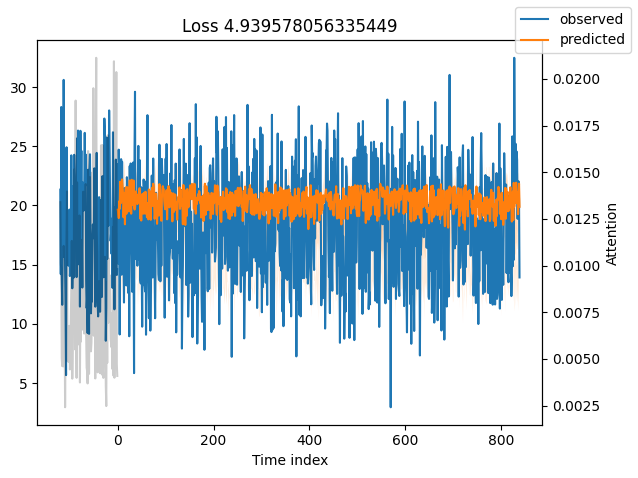

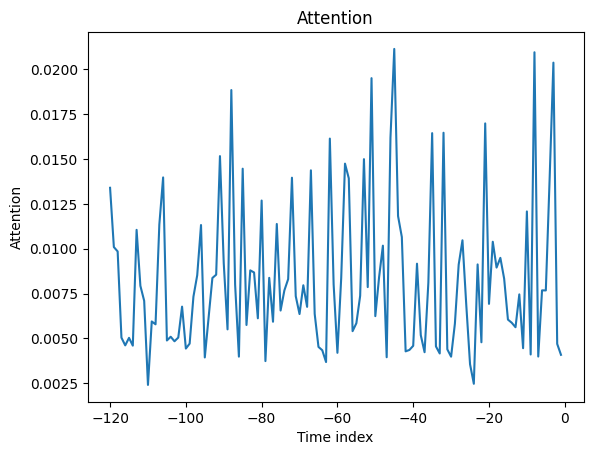

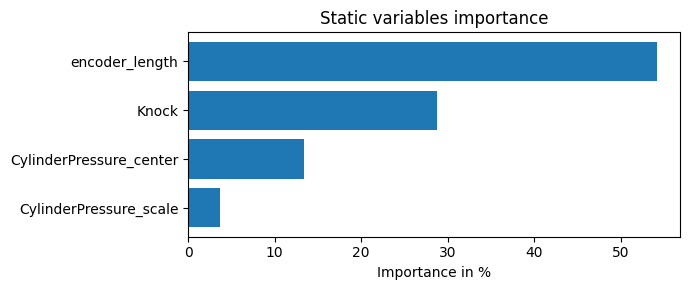

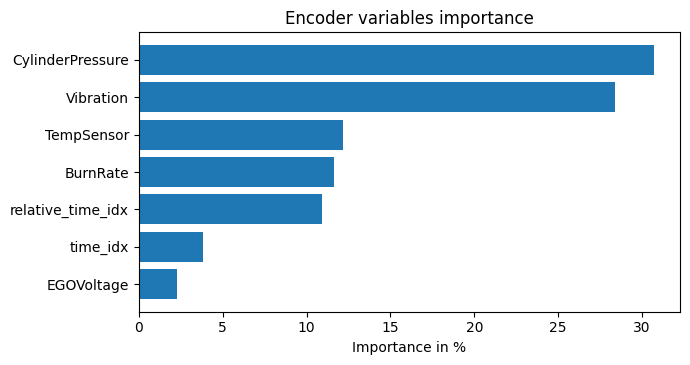

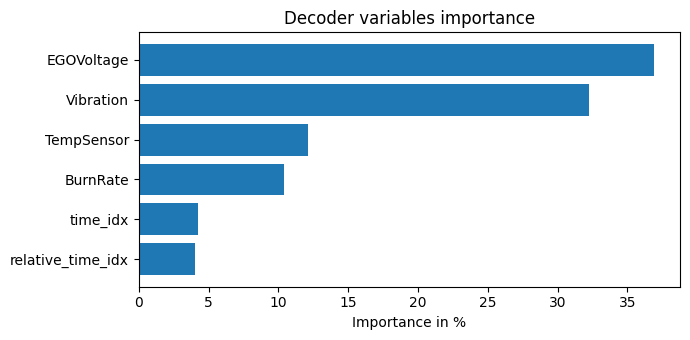

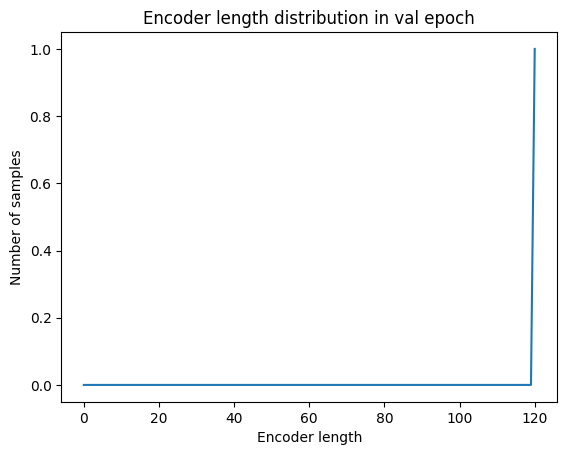

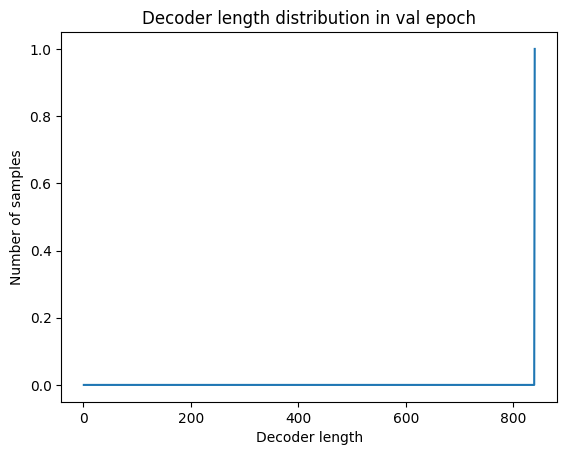

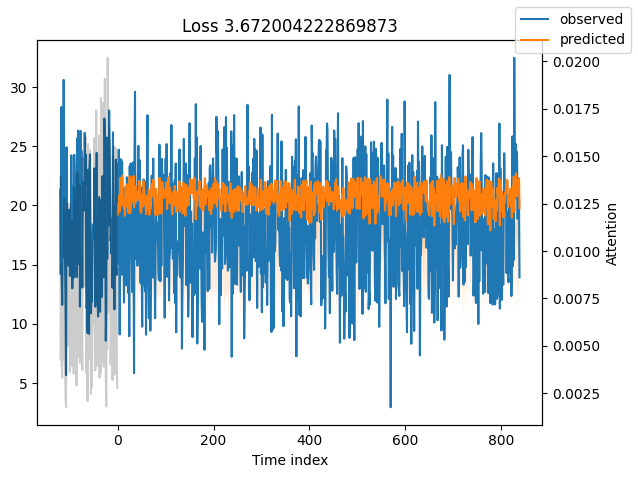

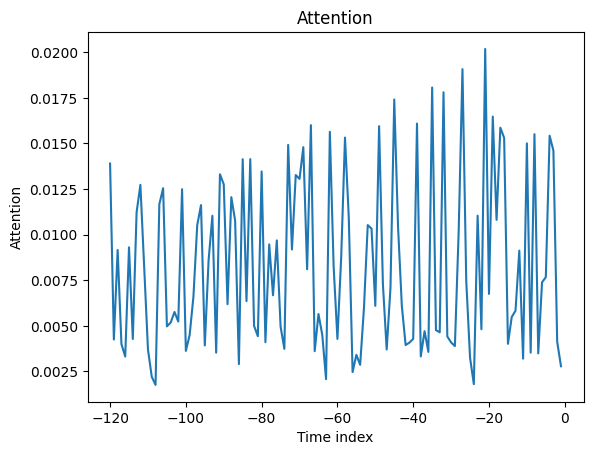

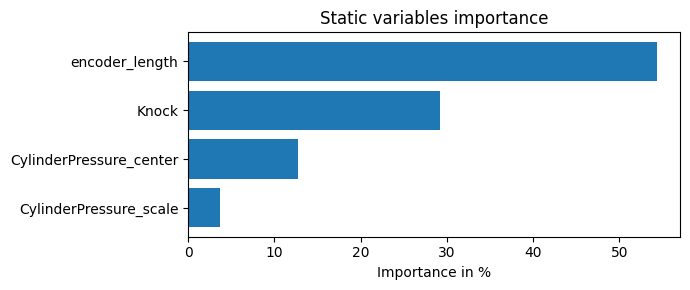

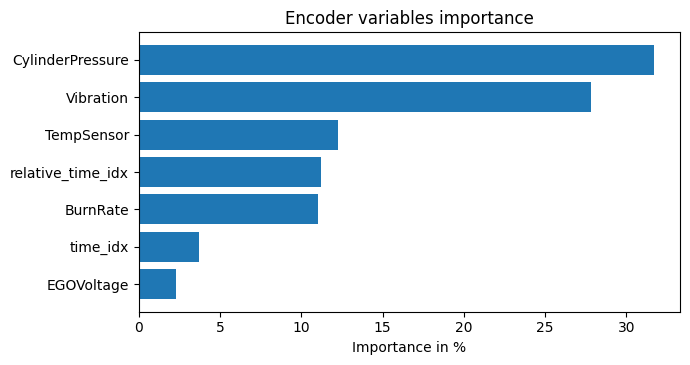

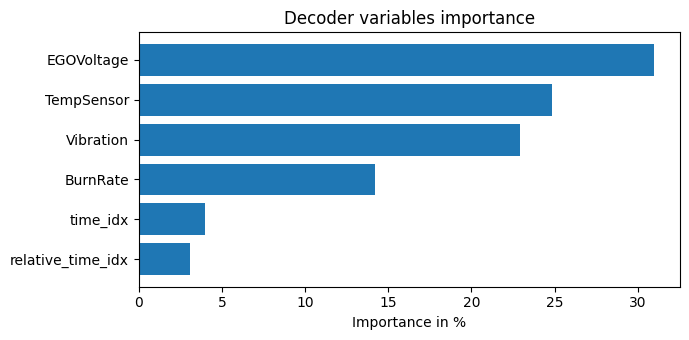

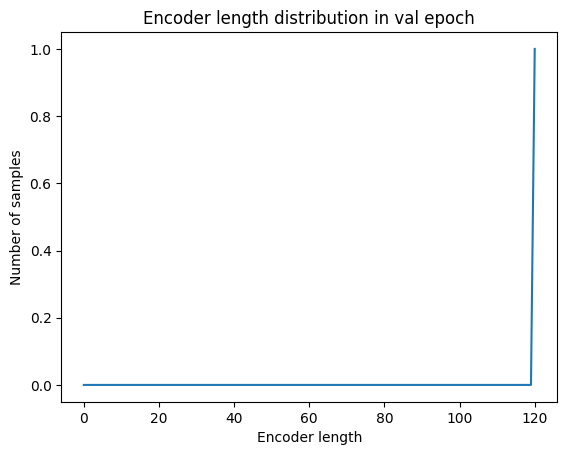

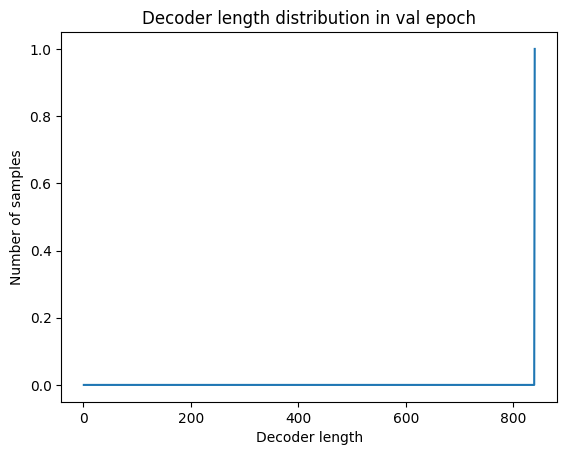

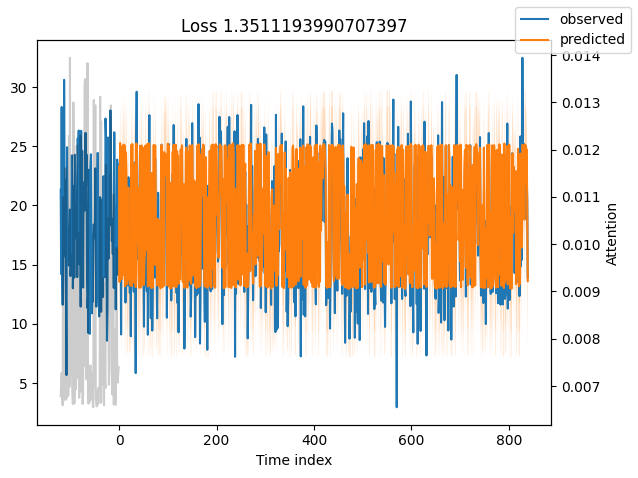

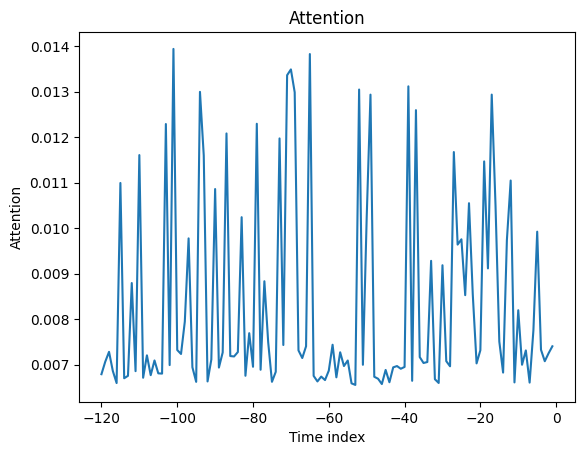

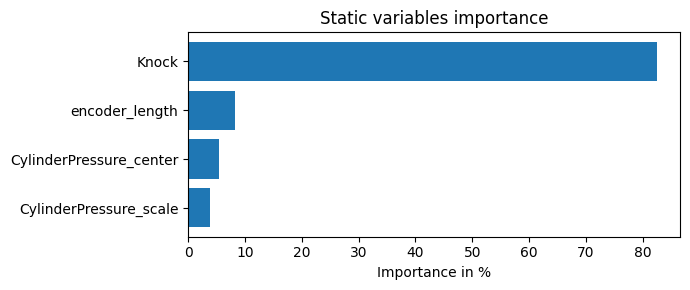

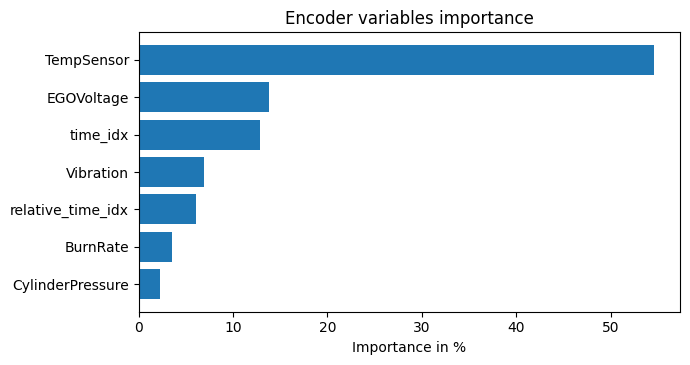

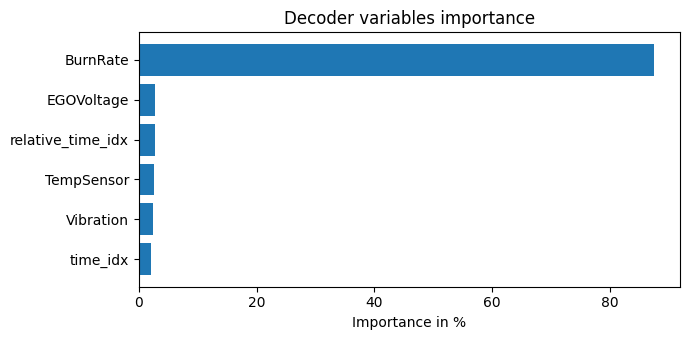

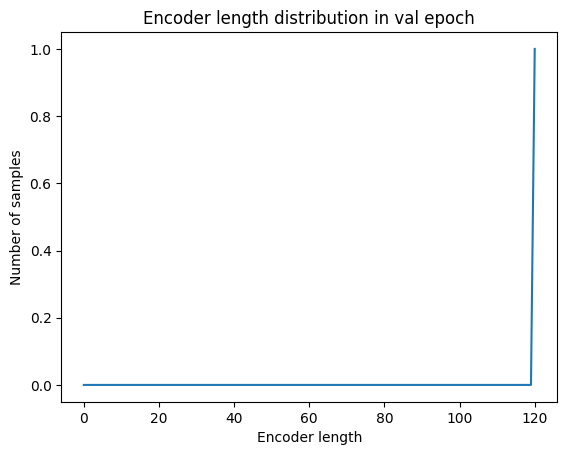

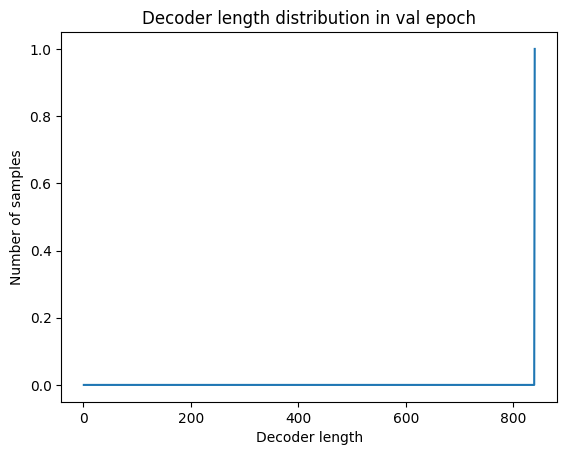

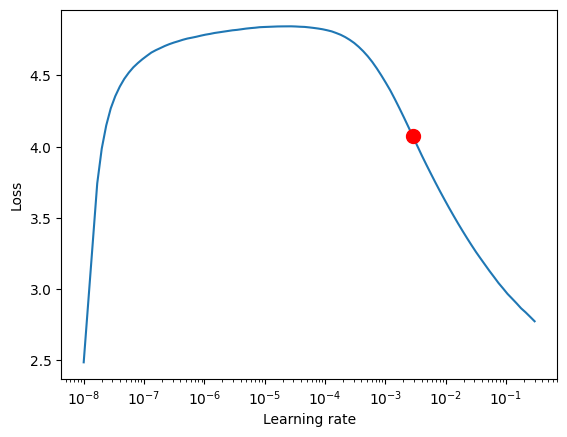

In [19]:
# find the optimal learning rate
res = Tuner(trainer).lr_find(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.3,
)
# and plot the result - always visually confirm that the suggested learning rate makes sense
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [27]:
# fit the model on the data - redefine the model with the correct learning rate if necessary
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 2      | train
3  | prescalers                         | ModuleDict                      | 320    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 5.8 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 14.0 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 11.9 K | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K  

Epoch 99: 100%|██████████| 30/30 [00:53<00:00,  0.56it/s, v_num=3, train_loss_step=0.643, val_loss=0.523, train_loss_epoch=0.639]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 30/30 [00:53<00:00,  0.56it/s, v_num=3, train_loss_step=0.643, val_loss=0.523, train_loss_epoch=0.639]


In [28]:
raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [29]:
raw_predictions

Prediction(output=Output(prediction=tensor([[[22.4786, 23.9070, 24.7614,  ..., 26.3645, 27.0869, 28.3579],
         [10.3979, 11.5881, 12.3339,  ..., 13.9548, 14.7299, 15.9612],
         [20.3562, 21.6434, 22.4092,  ..., 23.9312, 24.6467, 25.8939],
         ...,
         [17.7034, 18.9094, 19.6797,  ..., 21.2377, 22.0947, 23.4378],
         [16.6693, 18.2882, 19.3247,  ..., 21.4241, 22.5000, 24.2331],
         [14.5574, 15.9702, 16.9181,  ..., 18.9337, 20.0023, 21.5102]]],
       device='mps:0'), encoder_attention=tensor([[[[1.0040e-02, 5.8127e-03, 1.0227e-03,  ..., 8.8863e-03,
           4.1414e-02, 1.0043e-02]],

         [[1.0823e-02, 3.2862e-04, 5.5906e-03,  ..., 3.3878e-04,
           1.5717e-06, 1.8643e-04]],

         [[5.2166e-02, 9.1207e-04, 4.7788e-03,  ..., 1.4695e-03,
           7.8474e-05, 1.7451e-03]],

         ...,

         [[5.7880e-03, 3.7671e-03, 3.7513e-03,  ..., 8.0347e-03,
           9.6044e-05, 1.0764e-02]],

         [[9.3080e-03, 4.7327e-04, 3.3001e-03,  ..., 